# Machine Learning

Após discutir e decidir qual tema abordaríamos, o escolhido foi uma ideia abordando regressão onde :

- **Problema:** Prever o número de ocorrências.
- **Objetivo:** Auxiliar a segurança pública no policiamento e melhorar a infraestrutura urbana.

O tipo de aprendizado escolhido foi o *Supervisionado*.

Em relação as métricas escolhidas foram:
- **MAE e RMSE:** Avaliam a precisão das previsões em termos de magnitude do erro.
- **R²:** Mede o quão bem o modelo explica a variabilidade dos dados.

Bibliotecas necessárias para a preparação

In [37]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from unicodedata import normalize

## Exploração e Preparação

Foi realizada uma conversão dos arquivos para o padrão CSV afim de trabalharmos com o Pandas.

em seguida realizamos a conversão de algumas features, onde a função normalize_city é criada para converter em maiúscula, remover acentos, caracteres especiais e eliminar espaços desnacessários.

In [55]:
''' UNIFICAÇÃO DE ARQUIVOS '''
# Ler os arquivos CSV
dados_2022 = pd.read_csv('dados_csv/dados_2022.csv')
dados_2023 = pd.read_csv('dados_csv/dados_2023.csv')
dados_2024 = pd.read_csv('dados_csv/dados_2024.csv')


# Combinar os dados em um único DataFrame
dados = pd.concat([dados_2022, dados_2023, dados_2024], ignore_index=True)

# Adicionando descrição do dataset
def describe_dataset(df):
    print("Descrição do Dataset:")
    print(df.info())
    print("\nEstatísticas descritivas:\n", df.describe())
    print("\nPercentual de valores ausentes por coluna:\n", df.isna().mean() * 100)

describe_dataset(dados)


''' CONVERSÃO DE TIPOS '''
# Convertendo para Int
dados['ANO_ESTATISTICA'] = pd.to_numeric(dados['ANO_ESTATISTICA'], errors='coerce').astype('Int64')
dados['MES_ESTATISTICA'] = pd.to_numeric(dados['MES_ESTATISTICA'], errors='coerce').astype('Int64')

# Convertendo a feature no tipo string
dados['CIDADE'] = dados['CIDADE'].astype(str)

# Normalização das cidades
def normalize_city(city):
    city = city.lower()
    city = normalize('NFKD', city).encode('ascii', 'ignore').decode('utf-8')
    city = city.strip()
    city = city.replace('  ', ' ')  # Substitui múltiplos espaços por um único espaço
    return city

# Aplicação da normalização na feature CIDADE
dados['CIDADE'] = dados['CIDADE'].apply(normalize_city)

# Convertendo para tipo numérico
dados['LATITUDE'] = pd.to_numeric(dados['LATITUDE'], errors='coerce')
dados['LONGITUDE'] = pd.to_numeric(dados['LONGITUDE'], errors='coerce')


''' REEMOÇÃO DE NULOS '''
dados = dados.dropna(subset=['ANO_ESTATISTICA', 'MES_ESTATISTICA'])
dados = dados.dropna(subset=['LATITUDE', 'LONGITUDE'])
dados = dados.dropna(subset=['CIDADE'])


''' CRIAÇÃO DE FEATURES '''
# Dataframe desconsiderando os zeros
dados_limpos = dados[(dados['LATITUDE'] != 0) & (dados['LONGITUDE'] != 0)]
dados_limpos = dados_limpos.dropna(subset=['LATITUDE', 'LONGITUDE'])

# Calcular Latitude e Longitude central
media_geo_cidades = dados_limpos.groupby('CIDADE')[['LATITUDE', 'LONGITUDE']].median().reset_index()
media_geo_cidades.rename(columns={'LATITUDE': 'LATITUDE_MEDIAN', 'LONGITUDE': 'LONGITUDE_MEDIAN'}, inplace=True)

# Categorias de crimes
categories_crimes = {
    'Lesão Corporal': [
        'A.I. Lesão Corporal (art. 129 §12)',
        'A.I.-Lesão corporal (art 129 § 9º)',
        'A.I.-Lesão corporal (art. 129)',
        'A.I.-Lesão corporal culposa (art. 129. §6o.)',
        'A.I.-Lesão corporal culposa na direção de veículo automotor (Art. 303)',
        '"A.I.-Lesão corporal de natureza GRAVE (art. 129, §1o.)"',
        'LESAO CORPORAL (ART. 129)',
        'LESAO CORPORAL CULPOSA NA DIRECAO DE VEICULO AUTOMOTOR (ART. 303)',
        'Lesão corporal (Art. 27)',
        'Lesão corporal (art 129 § 9º)',
        'Lesão corporal (art. 129 §12)',
        'Lesão corporal (art. 129)',
        '"Lesão corporal (art. 129), Comunicação de óbito"',
        '"Lesão corporal (art. 129), Disparo de arma de fogo (art. 28)"',
        '"Lesão corporal (art. 129), Morte suspeita"',
        '"Lesão corporal (art. 129), Violência Doméstica"',
        'Lesão corporal (art.129)',
        'Lesão corporal culposa (art. 129. §6o.)',
        'Lesão corporal culposa na direção de veículo automotor (Art. 303)',
        '"Lesão corporal de natureza GRAVÍSSIMA (art. 129, §2o.)"',
        '"Lesão corporal de natureza GRAVE (art. 129, §1o.)"',
        '"Lesão corporal seguida de morte (art. 129, §3o.)"',
        '"Lesão corporal seguida de morte (art. 129, §3o.), Comunicação de Óbito"',
        '"Lesão corporal seguida de morte (art. 129, §3o.), Morte suspeita"',
        '"Lesão corporal seguida de morte (art. 129, §3o.), Omissão de socorro (Art. 135)"',
        'Choque',
        '"Morte suspeita, Choque"',
        '"Morte suspeita, Lesão corporal (art. 129)"',
        '"Resistência (art. 329), Lesão corporal (art. 129), Homicídio simples (art. 121)"',
        'Violência Doméstica',
        '"Violência Doméstica, Homicídio qualificado (art. 121, §2o.)"',
    ],
    'Homicídio': [
        '"A.I.-Homicídio qualificado (art. 121, §2o.)"',
        '"A.I.-Homicídio qualificado (art. 121, §2o.), Homicídio qualificado (art. 121, §2o.)"',
        'A.I.-Homicídio simples (art. 121)',
        '"A.I.-Homicídio simples (art. 121), Homicídio simples (art. 121)"',
        '"Estado de necessidade (art. 23, I), Homicídio simples (art. 121)"',
        '"Estado de necessidade (art. 23, I), Homicídio simples (art. 121), Localização/Apreensão de objeto"',
        '"Estado de necessidade (art. 23, I), Homicídio simples (art. 121), Roubo (art. 157)"',
        'Estelionato (art. 171)',
        '"Extorsão (art. 158), Homicídio simples (art. 121), Localização/Apreensão e Entrega de objeto, Roubo (art. 157)"',
        'Feminicídio',
        'HOMICIDIO (ART. 121)',
        'HOMICIDIO CULPOSO NA DIRECAO DE VEICULO AUTOMOTOR (ART. 302)',
        'HomicIdio (art. 121)',
        'HomicIdio culposo na direção de veIculo automotor (Art. 302)',
        'Homicídio (art. 121)',
        'Homicídio (art.121)',
        '"Homicídio culposo (art. 121, §3o.)"',
        'Homicídio culposo na direção de veículo automotor (Art. 302)',
        '"Homicídio qualificado (art. 121, §2o.)"',
        '"Homicídio qualificado (art. 121, §2o.), Captura de procurado"',
        '"Homicídio qualificado (art. 121, §2o.), Homicídio qualificado (art. 121, §2o.)"',
        '"Homicídio qualificado (art. 121, §2o.), Homicídio qualificado (art. 121, §2o.)','Homicídio qualificado (art. 121, §2o.), Homicídio qualificado (art. 121, §2o.), Estupro de vulneravel (art.217-A)"',
        '"Homicídio qualificado (art. 121, §2o.), Homicídio simples (art. 121)"',
        '"Homicídio qualificado (art. 121, §2o.), Localização/Apreensão de objeto"',
        '"Homicídio qualificado (art. 121, §2o.), Violência Doméstica"',
        'Homicídio simples (art. 121)',
        '"Homicídio simples (art. 121), A.I.-Homicídio simples (art. 121)"',
        '"Homicídio simples (art. 121), Comunicação de óbito"',
        '"Homicídio simples (art. 121), Destruição, subtração ou ocultação de cadáver (art. 211)"',
        '"Homicídio simples (art. 121), Drogas para consumo pessoal sem autorização ou em desacordo (Art.28,caput)"',
        '"Homicídio simples (art. 121), Estado de necessidade (art. 23, I)"',
        '"Homicídio simples (art. 121), Fraude processual (art. 347)"',
        '"Homicídio simples (art. 121), Homicídio simples (art. 121)"',
        '"Homicídio simples (art. 121), Lesão corporal (art. 129)"',
        '"Homicídio simples (art. 121), Lesão corporal culposa na direção de veículo automotor (Art. 303)"',
        '"Homicídio simples (art. 121), Localização/Apreensão de objeto"',
        '"Homicídio simples (art. 121), Localização/Apreensão de objeto, Localização/Apreensão de veículo"',
        '"Homicídio simples (art. 121), Localização/Apreensão de veículo"',
        '"Homicídio simples (art. 121), Localização/Apreensão de veículo, Localização/Apreensão de objeto"',
        '"Homicídio simples (art. 121), Morte suspeita"',
        '"Homicídio simples (art. 121), Resistência (art. 329), Roubo (art. 157)"',
        '"Homicídio simples (art. 121), Roubo (art. 157)"',
        '"Homicídio simples (art. 121), Roubo (art. 157), Adulteração de sinal identificador de veículo automotor (art. 311)"',
        '"Homicídio simples (art. 121), Violência Doméstica"',
        '"Morte suspeita, Homicídio simples (art. 121)"',
        '"Outros não criminal, Homicídio qualificado (art. 121, §2o.)"',
        '"Seqüestro e cárcere privado (art. 148), Homicídio simples (art. 121)"',
        'homicídio culposo',
    ],
    'Estupro': [
        'A.I.-Estupro (art.213)',
        'A.I.-Estupro de vulneravel (art.217-A)',
        'Art. 213 - Estupro',
        'Estupro - Art. 213',
        'Estupro de vulneravel (art.217-A)',
        '"Estupro de vulneravel (art.217-A), Homicídio qualificado (art. 121, §2o.), Tortura (Art. 1º)"',
        '"Estupro de vulneravel (art.217-A), Homicídio simples (art. 121)"',
    ],
    'Ameaça': [
        'A.I.-Ameaça (art. 147)',
        'Ameaça (art. 147)',
        '"Ameaça (art. 147), Violação de domicílio (art. 150), Dano (art. 163), Homicídio simples (art. 121), Lesão corporal (art. 129)"',
    ],
    'Furto': [
        'A.I.-Furto (art. 155)',
        'A.I.-Furto de coisa comum (art. 156)',
        '"A.I.-Furto qualificado (art. 155, §4o.)"',
        'Furto (art. 155)',
        '"Furto (art. 155), Lesão corporal seguida de morte (art. 129, §3o.)"',
        '"Furto (art. 155), Morte suspeita"',
        'Furto de coisa comum (art. 156)',
        '"Furto qualificado (art. 155, §4o.)"',
    ],
    'Roubo': [
        'A.I.-Roubo (art. 157)',
        '"Morte suspeita, Roubo (art. 157)"',
        'ROUBO (ART. 157)',
        'Receptação (art. 180)',
        'Roubo (art. 157)',
        '"Roubo (art. 157), Comunicação de óbito"',
        '"Roubo (art. 157), Disparo de arma de fogo (Art. 15)"',
        '"Roubo (art. 157), Estado de necessidade (art. 23, I)"',
        '"Roubo (art. 157), Homicídio simples (art. 121)"',
        '"Roubo (art. 157), Localização/Apreensão de veículo"',
        '"Roubo (art. 157), Localização/Apreensão e Entrega de veículo"',
        '"Roubo (art. 157), Localização/Apreensão e Entrega de veículo, Homicídio simples (art. 121), Legítima defesa (art. 23, II)"',
        '"Roubo (art. 157), Roubo (art. 157)"',
        '"Roubo (art. 157), Roubo (art. 157), Extorsão (art. 158)"',
        '"Roubo (art. 157), Roubo (art. 157), Roubo (art. 157)"',
    ],
    'Estelionato': [
        'COMUNICACAO DE OBITO',
        'Comunicação de óbito',
        '"Comunicação de óbito, Homicídio simples (art. 121)"',
        '"Comunicação de óbito, Roubo (art. 157)"',
    ],
    'Associação Criminosa': [
        '"A.I.-Associarem-se duas ou mais pessoas - arts. 33, caput e § 1o, e 34"',
        '"Art 2º - Promover, constituir, financiar ou integrar organização criminosa"',
        '"Associarem-se duas ou mais pessoas - arts. 33, caput e § 1o, e 34 (Art.35,caput)"',
        'Associação Criminosa (art. 288)',
        '"Associação para o tráfico (Art.35,caput)"',
        '"Colaborar com grupo, organização ou associação (Art.37)"',
        '"Financiar ou custear a prática dos crimes - arts.33, caput e §1º, e 34 (Art.36)"',
    ],
    'Crimes com Armas': [
        'A.I.-Posse irregular de arma de fogo de uso permitido (Art.12)',
        'A.I.-Receptação (art. 180)',
        'Disparo de arma de fogo (Art. 15)',
        'Porte de arma (art. 19)',
        'Porte ilegal de arma de fogo de uso permitido (Art. 14)',
        'Posse irregular de arma de fogo de uso permitido (Art.12)',
        'Posse ou porte ilegal de arma de fogo de uso restrito (Art. 16)',
    ],
    'Corrupção': [
        'A.I.-Caput Corromper ou facilitar a corrupção de menor de 18 anos (244B)',
        'Caput Corromper ou facilitar a corrupção de menor de 18 anos (244B)',
        'Coação no curso do processo (art. 344)',
        'Corrupção ativa (art. 333)',
        'Falsa identidade (art. 307)',
        'Uso de documento falso (art. 304)',
    ],
    'Crimes Relacionados à Drogas': [
        '"A.I.-Drogas para consumo pessoal sem autorização ou em desacordo (Art.28,caput)"',
        '"A.I.-Drogas sem autorização ou em desacordo (Art.33, caput)"',
        '"Drogas para consumo pessoal sem autorização ou em desacordo (Art.28,caput)"',
        '"Drogas sem autorização ou em desacordo (Art.33, caput)"',
        'Fabricação de drogas (Art.34)',
        'Fals/corr/adult/alt produtos terapêuticos/medicinais (art. 273)',
        '"Qq. objeto destinado a fabr., prep., prod. ou transformação de drogas (Art.34)"',
        '"tráfico drogas (Art.33, caput)"',
    ],
    'Crimes Relacionados à Veículos': [
        'A.I.-Adulteração de sinal identificador de veículo automotor (art. 311)', 
        'ATROPELAMENTO',
        'Abalroamento',
        'Adulteração de sinal identificador de veículo automotor (art. 311)',
        '"Art. 308-Participar, na direção de veículo automotor, em via pública, de corrida"',
        'Atropelamento',
        'Capotamento',
        'Colisão',
        'DIRIGIR SEM PERMISSAO OU HABILITACAO (ART. 309)',
        'Direção perigosa de veículo na via pública (art. 34)',
        'Dirigir sem Permissão ou Habilitação (Art. 309)',
        'Embriaguez ao volante (Art. 306)',
        '"Embriaguez ao volante (Art. 306), Homicídio simples (art. 121)"',
        'Engavetamento',
        'Entrega de veículo localizado/apreendido',
        'Falta de habilitação para dirigir veículo (art. 32)',
        'Fuga de local de acidente (Art. 305)',
        'Localização/Apreensão de veículo',
        'Localização/Apreensão e Entrega de veículo',
        'Trafegar em velocidade incompatível (Art. 311)',
    ],
    'Crimes Diversos': [
        'A.I.-Desacato (art. 331)',
        'A.I.-Desobediência (art. 330)',
        'Abandono de incapaz (art. 133)',
        'Apreensão de Adolescente',
        'Apropriação indébita (art. 168)',
        'Auto lesão',
        'Captura de procurado'
        '"Caput-Adquirir, possuir ou armazenar, por qualquer meio, fotografia, vídeo(241B)"',
        'Casa de prostituição (art.229)',
        'Constrangimento ilegal (art. 146)',
        'Contrabando (Art 334A )',
        'Cumprimento de mandado de busca e apreensão',
        'Cumprimento de mandado de prisão temporária',
        'Dano (art. 163)',
        '"Dano (art. 163), Homicídio simples (art. 121), Resistência (art. 329), Roubo (art. 157)"',
        '"Dano qualificado (art. 163, par.único, I)"',
        '"Dano qualificado (art.163,par.único, III)"',
        'Deixar a empresa de cumprir as normas de segurança e higiene (Art. 19)',
        'Desacato (art. 331)',
        'Desaparecimento de pessoa',
        'Descaminho (Art 334)',
        'Descumprimento de medida protetiva de urgência (art. 24-A)',
        'Desobediência (art. 330)',
        'Destruir ou danificar vegetação primária ou secundária(Art.38-A)',
        '"Destruição, subtração ou ocultação de cadáver (art. 211)"',
        '"Destruição, subtração ou ocultação de cadáver (art. 211), Homicídio simples (art. 121)"',
        'Entrada ilegal de aparelho movél de comunicação em estabelecimento prisional',
        'Entrega de objeto localizado/apreendido',
        '"Explosão (art. 251), Seqüestro e cárcere privado (art. 148)"',
        'Extorsão mediante seqüestro (art. 159)',
        'Favorecimento pessoal (art. 348)',
        'Fraude processual (art. 347)',
        '"Incêndio (art. 250, caput)"',
        '"Incêndio (art. 250, caput), Morte suspeita"',
        'Indeferido',
        'Injúria (art. 140)',
        'Instigação ao suicídio (Art. 122)',
        'Irregularidades Funcionais',
        'Jogo de azar (art. 50)',
        'Localização/Apreensão de objeto',
        '"Localização/Apreensão de objeto, Roubo (art. 157)"',
        'Localização/Apreensão e Entrega de objeto',
        'MORTE SUSPEITA',
        'Morte natural',
        'Morte suspeita',
        'Omissão de socorro (Art. 135)',
        'Omissão de socorro (Art. 304)',
        'Outros não criminal',
        'Resistência (art. 329)',
        'Suicídio consumado',
        'Suicídio tentado',
        'Supressão de documento (art. 305)',
        'Tombamento',
        'Tortura (Art. 1º)',
        'ilícito extrapenal (tema 506 STF)',
    ]
}

def mapear_categoria(rubrica):
    for categoria, rubricas in categories_crimes.items():
        if rubrica in rubricas:
            return categoria
    return 'Crimes Diversos'  # Se não encontrar uma correspondência, retorna None

# Criando a nova coluna 'categorias'
dados['CATEGORIA_CRIME'] = dados['RUBRICA'].apply(mapear_categoria)


''' AGREGAÇÃO DOS DADOS '''
# Agregar os dados por ano, mês, cidade e tipo de crime
dados_agregados = (
    dados.groupby(['ANO_ESTATISTICA', 'MES_ESTATISTICA', 'CIDADE', 'CATEGORIA_CRIME'])
    .size()
    .reset_index(name='NUM_OCORRENCIAS')
)

# Adicionar mediana das coordenadas geográficas nos dados agregados
dados_agregados = dados_agregados.merge(media_geo_cidades, on='CIDADE', how='left')

# Ordenar os dados de acordo com MES/ANO de ocorrência
dados_agregados = dados_agregados.sort_values(by=['ANO_ESTATISTICA', 'MES_ESTATISTICA'])

# Criar coluna de DATA nos dados agregados
dados_agregados['DATA'] = pd.to_datetime(
    dados_agregados['ANO_ESTATISTICA'].astype(str) + '-' +
    dados_agregados['MES_ESTATISTICA'].astype(str) + '-01'
)

# Salvar os dados agregados em um CSV para análise
dados_agregados.to_csv('dados_agregados.csv', index=False)


C:\Users\kalma\AppData\Local\Temp\ipykernel_6848\4227938934.py:3: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  dados_2022 = pd.read_csv('dados_csv/dados_2022.csv')
C:\Users\kalma\AppData\Local\Temp\ipykernel_6848\4227938934.py:4: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  dados_2023 = pd.read_csv('dados_csv/dados_2023.csv')
C:\Users\kalma\AppData\Local\Temp\ipykernel_6848\4227938934.py:5: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  dados_2024 = pd.read_csv('dados_csv/dados_2024.csv')


Descrição do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3433822 entries, 0 to 3433821
Data columns (total 29 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   NOME_DEPARTAMENTO                object 
 1   NOME_SECCIONAL                   object 
 2   NOME_DELEGACIA                   object 
 3   CIDADE                           object 
 4   NUM_BO                           object 
 5   ANO_BO                           int64  
 6   DATA_COMUNICACAO_BO              object 
 7   DATA_OCORRENCIA_BO               object 
 8   HORA_OCORRENCIA_BO               object 
 9   DESCR_PERIODO                    object 
 10  DESCR_TIPOLOCAL                  object 
 11  BAIRRO                           object 
 12  LOGRADOURO                       object 
 13  NUMERO_LOGRADOURO                object 
 14  LATITUDE                         object 
 15  LONGITUDE                        float64
 16  NOME_DELEGACIA_CIRCUNSCRIÇÃO    

realizamos a divisão de um conjunto de dados em dois subconjuntos, treino e teste, com base em uma proporção definida (80% para treino e 20% para teste). Ele também salva os conjuntos gerados em arquivos CSV para validação.

Por se tratar de uma série temporal, os dados não foram divididos de forma aleatória, mas seguindo a ordem cronológica de ocorrências.

In [26]:
# Definir a proporção de divisão (80/20)
proporcao_treino = 0.8
limite_treino = int(len(dados_agregados) * proporcao_treino)

# Dividir os dados ordenados
dados_treino = dados_agregados.iloc[:limite_treino]
dados_teste = dados_agregados.iloc[limite_treino:]

# Verificar o tamanho dos conjuntos de dados
print(dados_agregados.shape)
print(dados_teste.shape)
print(dados_treino.shape)

# Salvar os conjuntos de dados para validação
dados_treino.to_csv('dados_treino.csv', index=False)
dados_teste.to_csv('dados_teste.csv', index=False)

print("Divisão concluída. Dados salvos como 'dados_treino.csv' e 'dados_teste.csv'.")

(76350, 8)
(15270, 8)
(61080, 8)
Divisão concluída. Dados salvos como 'dados_treino.csv' e 'dados_teste.csv'.


Para as colunas CIDADE e RUBRICA exibindo os valores únicos, monstrando a contagem de ocorrência de cada valor único.

In [56]:
treino = pd.read_csv("dados_treino.csv")
teste = pd.read_csv("dados_teste.csv")

treino.info()
treino.head()
treino.tail()

print(treino.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61080 entries, 0 to 61079
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ANO_ESTATISTICA  61080 non-null  int64  
 1   MES_ESTATISTICA  61080 non-null  int64  
 2   CIDADE           61078 non-null  object 
 3   CATEGORIA_CRIME  61080 non-null  object 
 4   NUM_OCORRENCIAS  61080 non-null  int64  
 5   LATITUDE_MEDIA   61076 non-null  float64
 6   LONGITUDE_MEDIA  61076 non-null  float64
 7   DATA             61080 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 3.7+ MB
       ANO_ESTATISTICA  MES_ESTATISTICA  NUM_OCORRENCIAS  LATITUDE_MEDIA  \
count     61080.000000     61080.000000     61080.000000    61076.000000   
mean       2022.736149         5.947200        38.763130      -22.338315   
std           0.685931         3.528936       494.613604        1.161028   
min        2022.000000         1.000000         1.000000      -28.

### Ocorrência de crimes ao longo do tempo

C:\Users\kalma\AppData\Local\Temp\ipykernel_6848\2242655061.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=treino, x='NUM_OCORRENCIAS', y='DATA', ci=None)


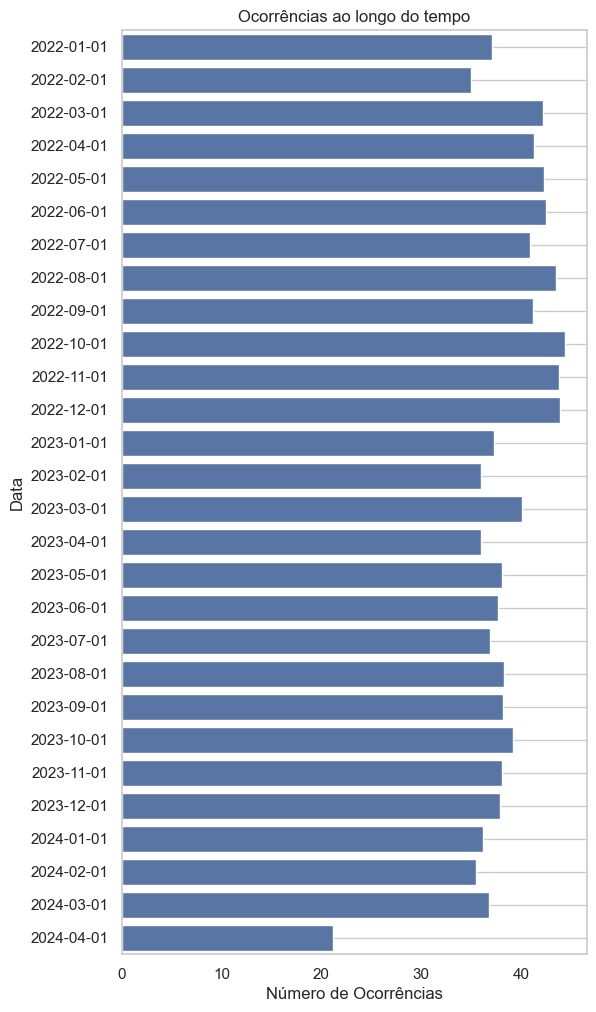

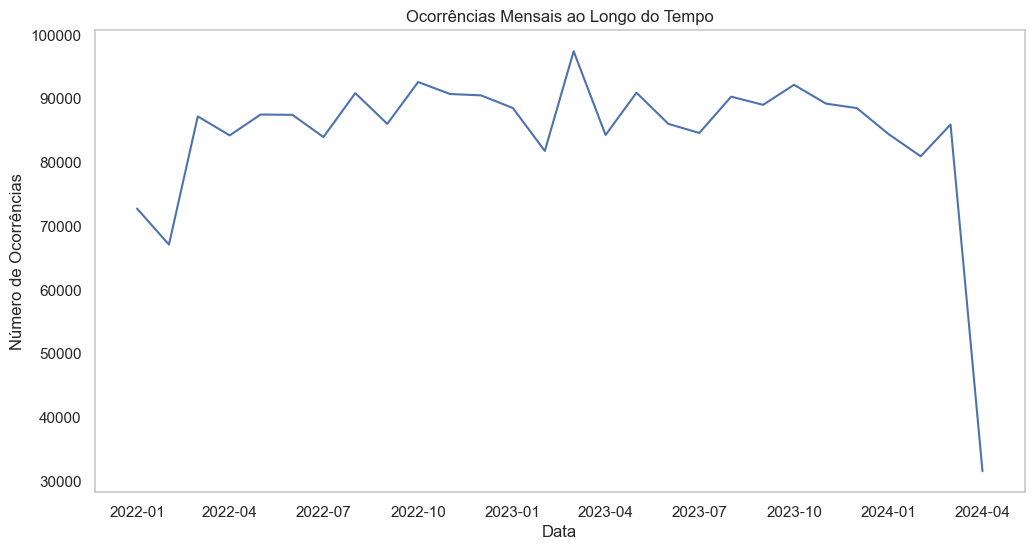

In [50]:
# Gráfico de ocorrências por mês

plt.figure(figsize=(6, 12))
sns.barplot(data=treino, x='NUM_OCORRENCIAS', y='DATA', ci=None)
plt.title('Ocorrências ao longo do tempo')
plt.ylabel('Data')
plt.xlabel('Número de Ocorrências')

plt.grid()
plt.show()

# Certifique-se de que 'DATA' está no formato datetime
treino['DATA'] = pd.to_datetime(treino['DATA'], errors='coerce')

# Agrupe os dados por período mensal
mensal = (
    treino.groupby(treino['DATA'].dt.to_period('M'))
    .sum(numeric_only=True)  # Considera apenas colunas numéricas
    .reset_index()
)

# Converta o período de volta para timestamps para plotagem
mensal['DATA'] = mensal['DATA'].dt.to_timestamp()

# Plotando os dados agregados
plt.figure(figsize=(12, 6))
sns.lineplot(data=mensal, x='DATA', y='NUM_OCORRENCIAS')
plt.title('Ocorrências Mensais ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Número de Ocorrências')
plt.grid()
plt.show()

### Ocorrência de crimes ao por CIDADE

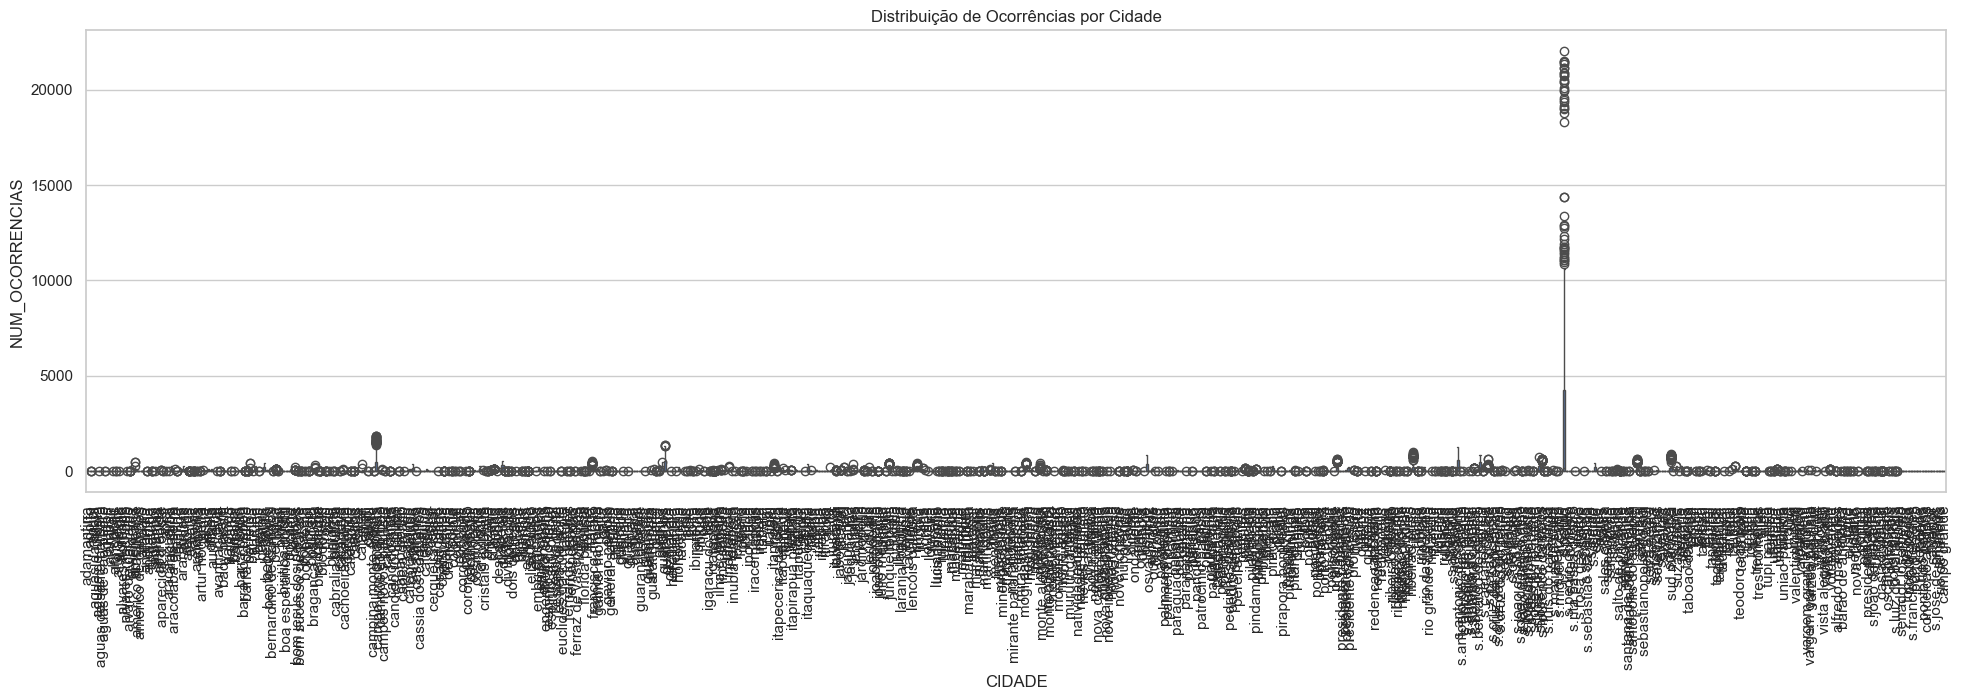

In [44]:
# Gráfico de ocorrencias por cidade

plt.figure(figsize=(24, 6))
sns.boxplot(data=treino, x='CIDADE', y='NUM_OCORRENCIAS')
plt.title('Distribuição de Ocorrências por Cidade')
plt.xticks(rotation=90)
plt.show()

### Crimes mais frequentes

C:\Users\kalma\AppData\Local\Temp\ipykernel_6848\2121299786.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(dados_treino,


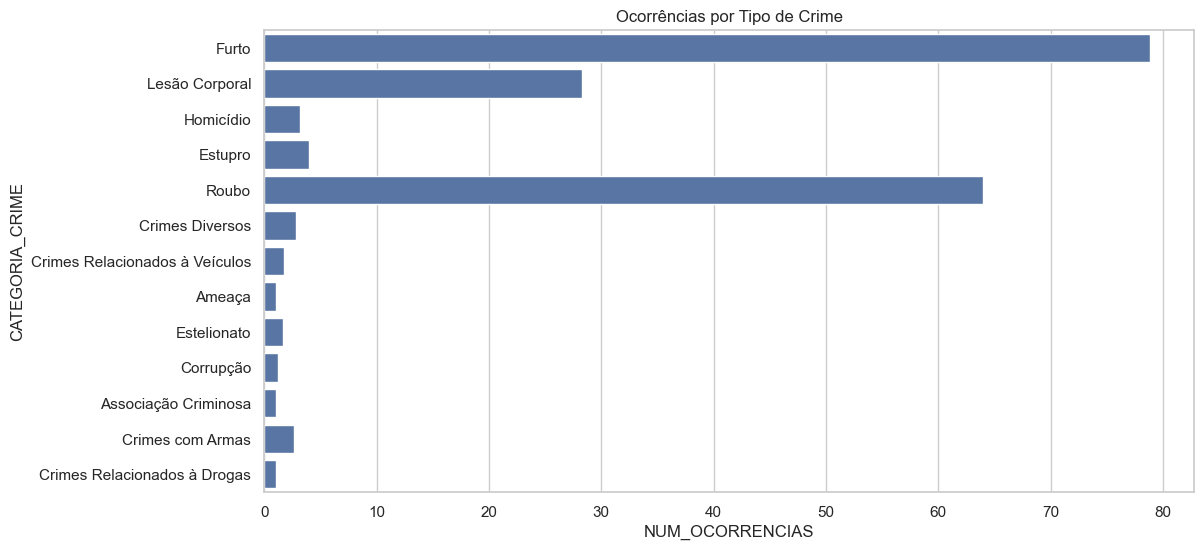

In [45]:
# Gráfico de ocorrências por tipo de crime

plt.figure(figsize=(12, 6))
sns.barplot(dados_treino,
            x='NUM_OCORRENCIAS', y='CATEGORIA_CRIME', ci=None)
plt.title('Ocorrências por Tipo de Crime')
plt.show()

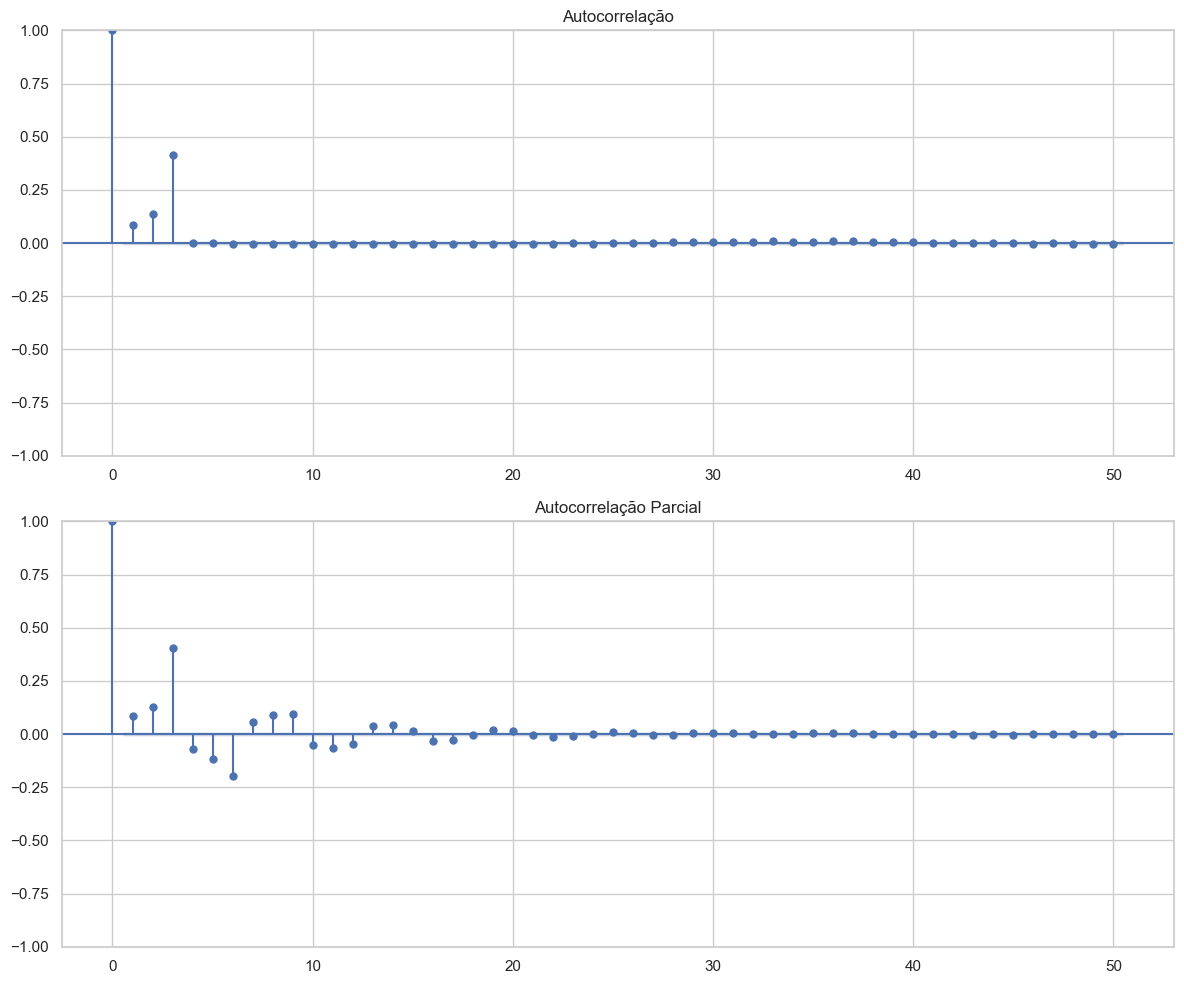

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(treino['NUM_OCORRENCIAS'], ax=ax[0], lags=50)
ax[0].set_title('Autocorrelação')
plot_pacf(treino['NUM_OCORRENCIAS'], ax=ax[1], lags=50)
ax[1].set_title('Autocorrelação Parcial')
plt.tight_layout()
plt.show()

### Matriz de Correlação

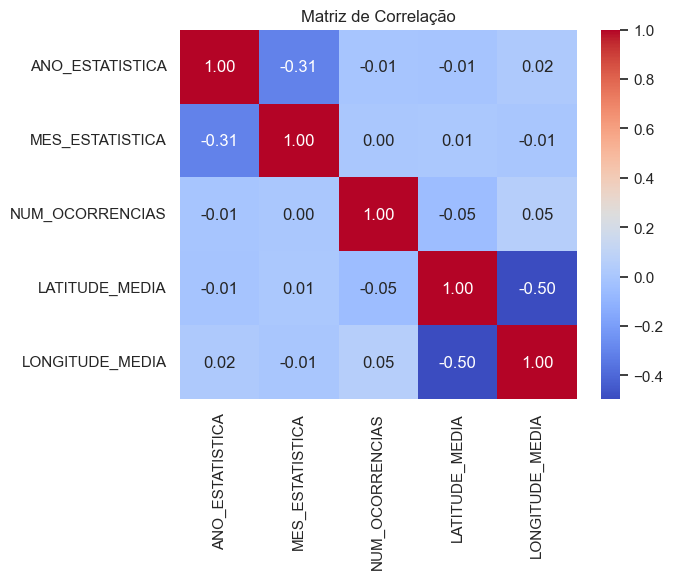

In [57]:
correlacoes = treino.corr(numeric_only=True)
sns.heatmap(correlacoes, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

O código apresentado demonstra o processo que seguimos para realizar a análise e o tratamento de um conjunto de dados temporais. Carregamos inicialmente o arquivo `dados_treino.csv`, configurando a coluna `DATA` como índice do DataFrame após convertê-la para o formato de data. Em seguida, utilizamos uma função personalizada (`describe_dataset`) para descrever o dataset, exibindo informações como tipos de dados, estatísticas descritivas e percentuais de valores ausentes por coluna. Identificamos valores ausentes e tratamos esses dados utilizando a técnica de interpolação "forward fill" (`ffill`), garantindo a consistência temporal.

Realizamos também a identificação de outliers utilizando boxplots para variáveis numéricas, o que nos permitiu visualizar possíveis anomalias. Para preparar os dados para uso em modelos preditivos, normalizamos as variáveis numéricas com o método `MinMaxScaler`. Após isso, reamostramos os dados para agregação mensal, o que possibilitou uma análise mais ampla das tendências e sazonalidades, que representamos graficamente.

Decompusemos a série temporal mensal para identificar separadamente os componentes de tendência, sazonalidade e ruído. Por fim, analisamos a autocorrelação e a autocorrelação parcial, que nos ajudaram a compreender a dependência temporal entre os períodos consecutivos. Registramos os principais aprendizados e resultados dessa análise em um arquivo de documentação, destacando o tratamento de valores ausentes, a detecção de outliers, o escalonamento dos dados, a identificação de padrões sazonais e as correlações temporais.

Descrição inicial dos dados carregados:

Descrição do Dataset:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 99944 entries, 2022-01-01 to 2024-04-01
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ANO_ESTATISTICA  99944 non-null  int64  
 1   MES_ESTATISTICA  99944 non-null  int64  
 2   CIDADE           99942 non-null  object 
 3   RUBRICA          99944 non-null  object 
 4   NUM_OCORRENCIAS  99944 non-null  int64  
 5   LATITUDE_MEDIA   99940 non-null  float64
 6   LONGITUDE_MEDIA  99940 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 6.1+ MB
None

Estatísticas descritivas:
        ANO_ESTATISTICA  MES_ESTATISTICA  NUM_OCORRENCIAS  LATITUDE_MEDIA  \
count     99944.000000     99944.000000     99944.000000    99940.000000   
mean       2022.710018         5.852047        24.783279      -22.387365   
std           0.673688         3.545668       384.596586        1.149063   

C:\Users\kalma\AppData\Local\Temp\ipykernel_25360\3760758394.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Interpolação forward-fill


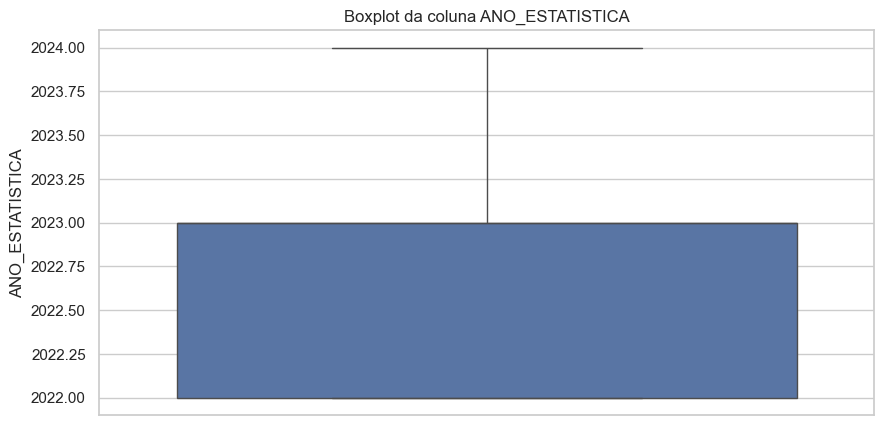

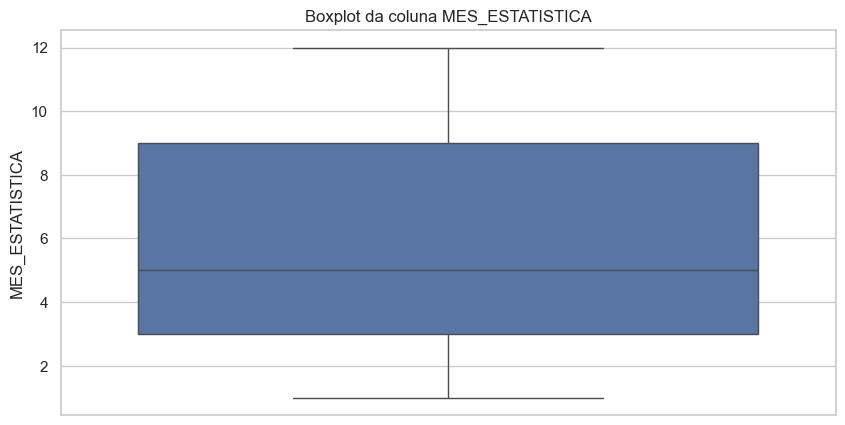

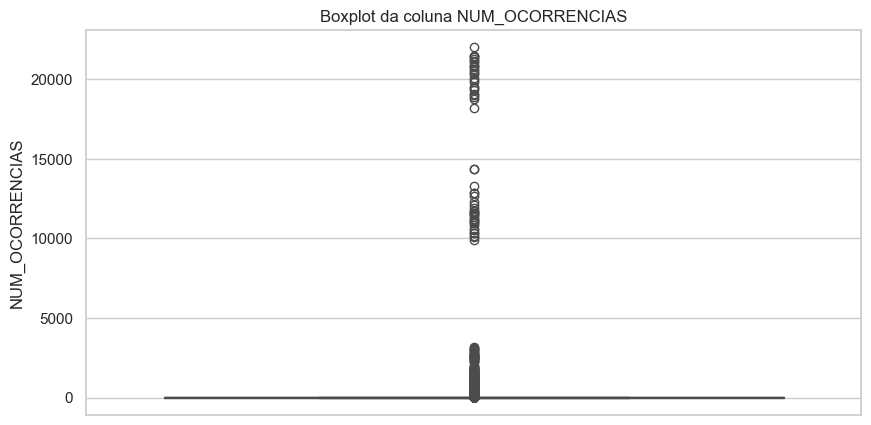

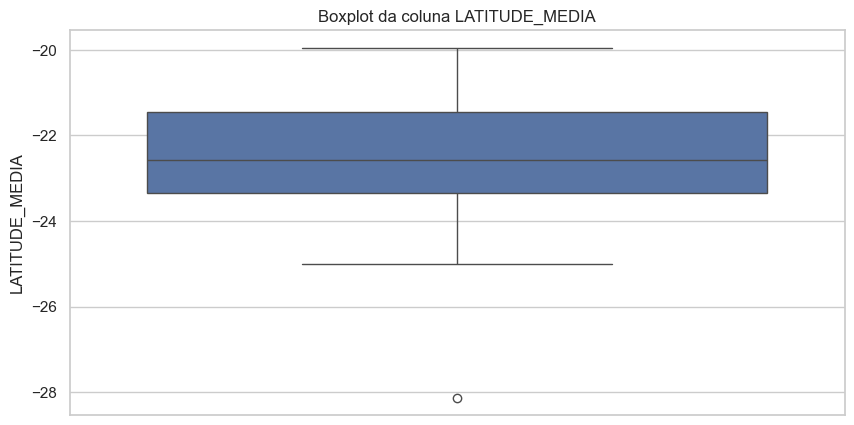

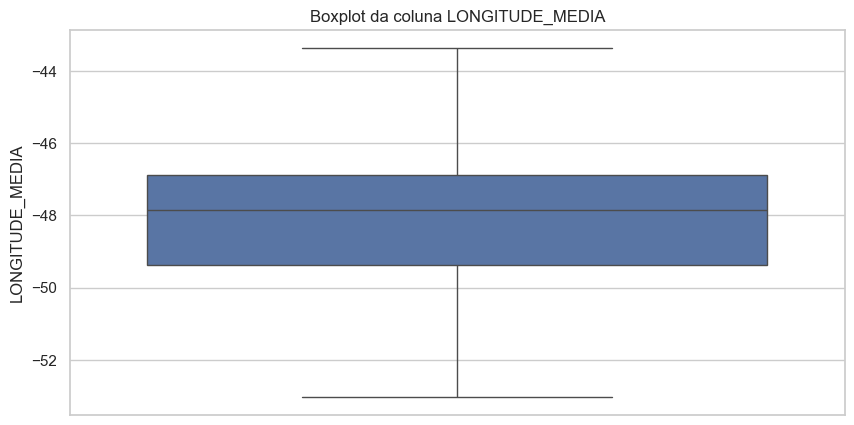

C:\Users\kalma\AppData\Local\Temp\ipykernel_25360\3760758394.py:39: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data.resample('M').sum()


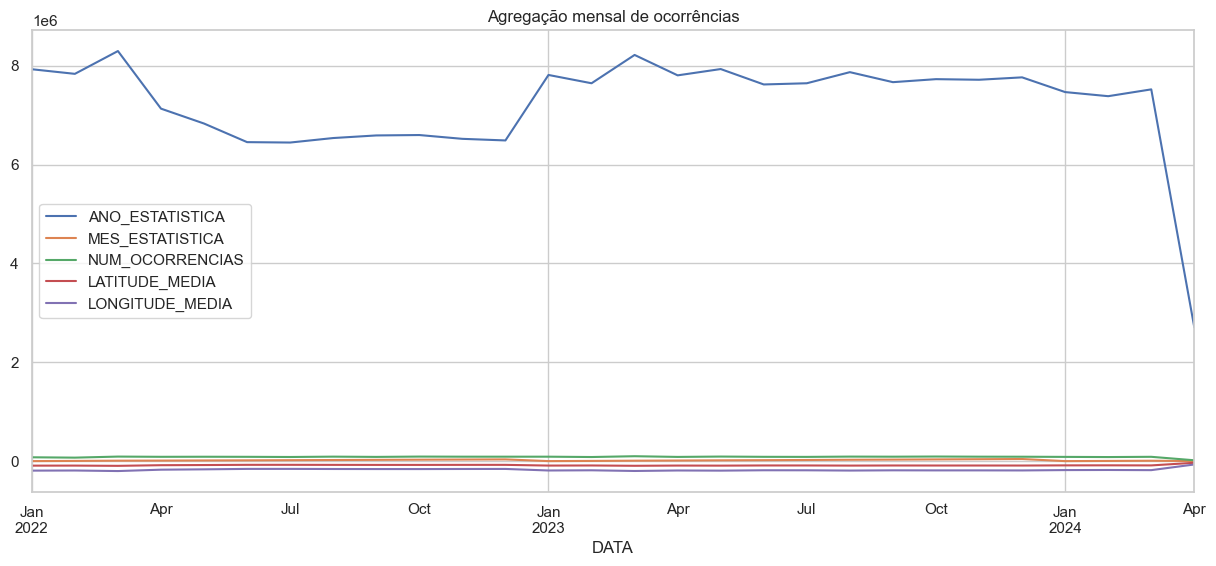

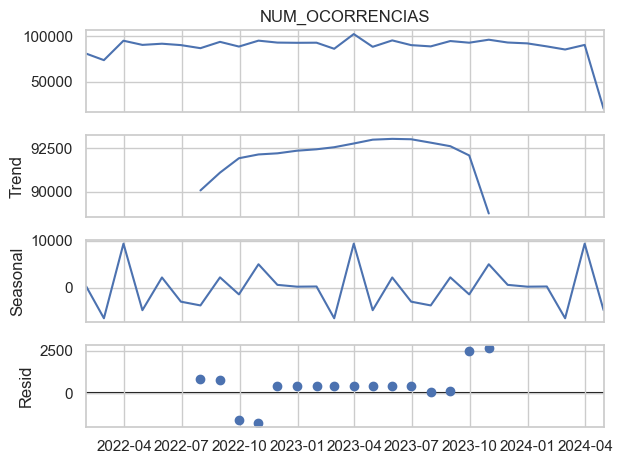

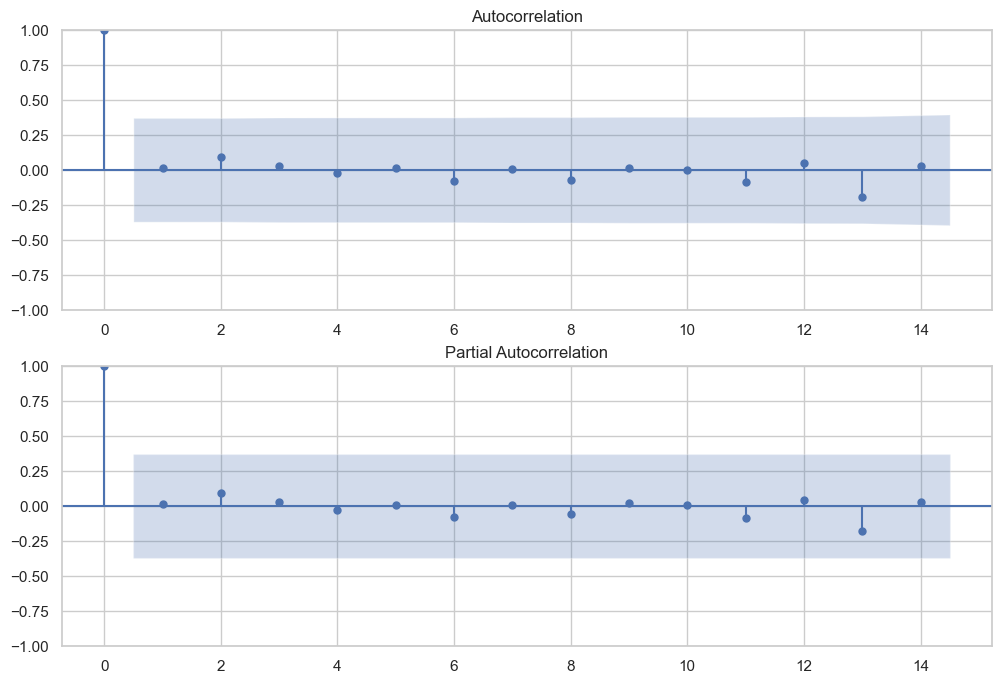

In [19]:
treino['DATA'] = pd.to_datetime(treino['DATA'])
treino.set_index('DATA', inplace=True)

# Chamando a função para descrever o dataset
print("Descrição inicial dos dados carregados:\n")
describe_dataset(treino)

# Tratamento de valores ausentes
# Estratégia: Preenchendo com 0 ou interpolação para dados temporais
missing_values = data.isna().sum()
if missing_values.sum() > 0:
    print("\nTratando valores ausentes...")
    data.fillna(method='ffill', inplace=True)  # Interpolação forward-fill

# Visualização de outliers utilizando boxplots
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data[column])
    plt.title(f"Boxplot da coluna {column}")
    plt.show()

# Escalonamento dos dados (normalização)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data.select_dtypes(include=['float64', 'int64']))
data_normalized = pd.DataFrame(data_normalized, columns=data.select_dtypes(include=['float64', 'int64']).columns, index=data.index)

# Série temporal agregada mensalmente
monthly_data = data.resample('M').sum()
monthly_data.plot(figsize=(15, 6), title="Agregação mensal de ocorrências", legend=True)
plt.show()

# Decomposição sazonal para identificar componentes
result = seasonal_decompose(monthly_data['NUM_OCORRENCIAS'], model='additive')
result.plot()
plt.show()

# Análise de autocorrelação
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(monthly_data['NUM_OCORRENCIAS'], ax=ax[0])
plot_pacf(monthly_data['NUM_OCORRENCIAS'], ax=ax[1])
plt.show()

# Documentação do aprendizado e resultados
with open('documentacao_analise.txt', 'w') as doc:
    doc.write("Aprendizados da Análise:\n")
    doc.write("1. Dados ausentes foram preenchidos utilizando forward-fill.\n")
    doc.write("2. Detecção de outliers foi realizada, sugerindo que dados anômalos devem ser revisados.\n")
    doc.write("3. Dados foram escalonados para uso em modelos preditivos.\n")
    doc.write("4. A decomposição sazonal destacou tendências e padrões recorrentes nos dados.\n")
    doc.write("5. Correlações temporais indicaram dependência significativa entre meses consecutivos.\n")

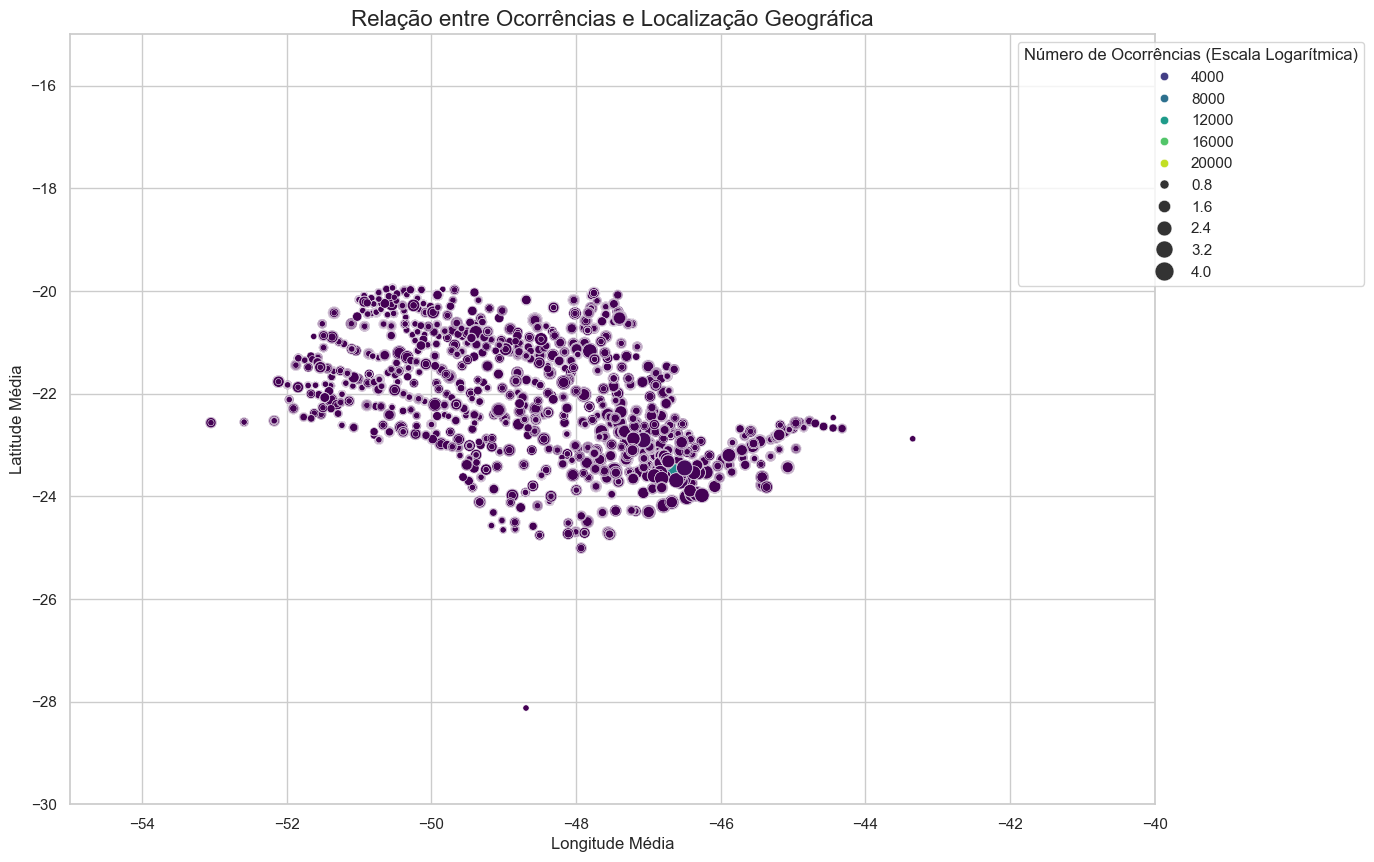

In [18]:
# Configurar o estilo do gráfico
sns.set(style="whitegrid")

# Ajustar os limites dos eixos
plt.figure(figsize=(14, 10))
plt.xlim(-55, -40)
plt.ylim(-30, -15)

# Aplicar escala logarítmica ao tamanho dos pontos e personalizar a paleta de cores
scatter = sns.scatterplot(
    x='LONGITUDE_MEDIA',
    y='LATITUDE_MEDIA',
    size=np.log10(treino['NUM_OCORRENCIAS'] + 1),
    hue=treino['NUM_OCORRENCIAS'],
    sizes=(20, 200),
    palette="viridis",
    data=treino
)

# Adicionar rótulos e título
plt.title("Relação entre Ocorrências e Localização Geográfica", fontsize=16)
plt.xlabel("Longitude Média", fontsize=12)
plt.ylabel("Latitude Média", fontsize=12)

# Adicionar legenda
plt.legend(title="Número de Ocorrências (Escala Logarítmica)", loc="upper right", bbox_to_anchor=(1.2, 1))

plt.show()

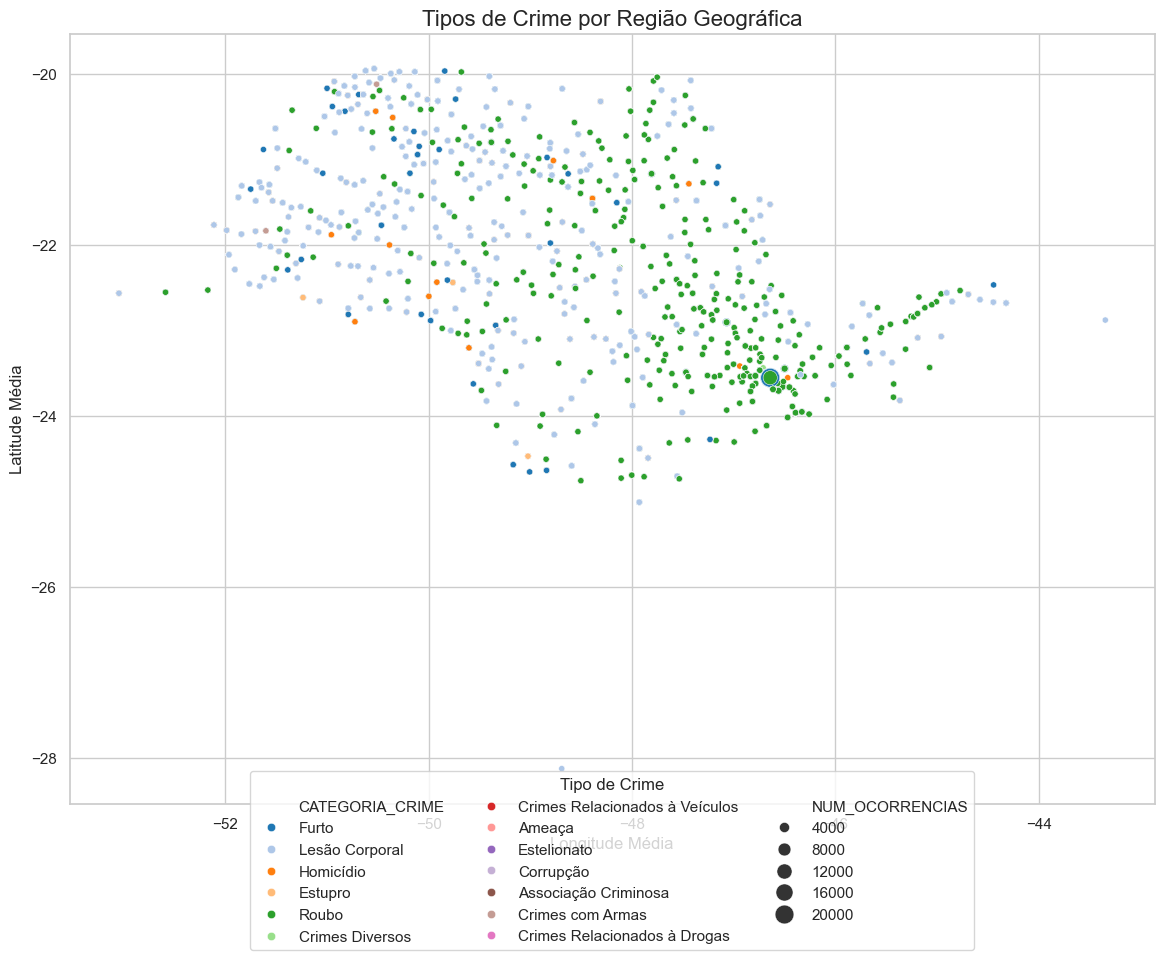

In [36]:
# Configurar o estilo do gráfico
sns.set(style="whitegrid")

# Criar o scatterplot com diferenciação por tipo de crime
plt.figure(figsize=(14, 10))
scatter = sns.scatterplot(
    x='LONGITUDE_MEDIA',
    y='LATITUDE_MEDIA',
    hue='CATEGORIA_CRIME',  # Diferenciar por tipo de crime
    size='NUM_OCORRENCIAS',
    sizes=(20, 200),
    palette='tab20',  # Paleta de cores com categorias distintas
    data=dados_treino
)

# Adicionar título e rótulos
plt.title("Tipos de Crime por Região Geográfica", fontsize=16)
plt.xlabel("Longitude Média", fontsize=12)
plt.ylabel("Latitude Média", fontsize=12)

# Posicionar a legenda abaixo do gráfico
plt.legend(
    title="Tipo de Crime",
    loc="lower center",           # Localização na parte inferior central
    bbox_to_anchor=(0.5, -0.2),  # Ajuste vertical (-0.2) para descer a legenda
    ncol=3,                      # Número de colunas na legenda (ajuste conforme necessário)
    frameon=True                 # Adiciona um quadro à legenda (opcional)
)

# Mostrar o gráfico
plt.show()
